# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Muhammad Ikhwananda Rizaldi
- Email: aldirizaldy977@gmail.com
- Id Dicoding: ikhwananda
- Id Cohort: A258YAF258

## Persiapan

### Menyiapkan library yang dibutuhkan dan Menyiapkan data yang akan digunakan

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

employee_data = pd.read_csv('./data/employee_data.csv')

## Data Understanding

In [2]:
# Now that we've loaded the data, let's explore it
print("Data information:")
print(employee_data.info())

print("\nChecking for missing values:")
print(employee_data.isnull().sum())

print("\nBasic statistics:")
employee_data.describe().T

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
employee_data.head()

Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int

,EmployeeId,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,38,NaN,Travel_Frequently,1444,Human Resources,1,4,Other,1,...,2,80,1,7,2,3,6,2,1,2
1,2,37,1.0,Travel_Rarely,1141,Research & Development,11,2,Medical,1,...,1,80,0,15,2,1,1,0,0,0
2,3,51,1.0,Travel_Rarely,1323,Research & Development,4,4,Life Sciences,1,...,3,80,3,18,2,4,10,0,2,7
3,4,42,0.0,Travel_Frequently,555,Sales,26,3,Marketing,1,...,4,80,1,23,2,4,20,4,4,8
4,5,40,NaN,Travel_Rarely,1194,Research & Development,2,4,Medical,1,...,2,80,3,20,2,3,5,3,0,2


In [3]:
# Calculate the attrition rate
attrition_count = employee_data['Attrition'].value_counts()
valid_attrition = employee_data['Attrition'].dropna()
attrition_rate = (valid_attrition.sum() / len(valid_attrition)) * 100

print(f"Attrition count: {attrition_count}")
print(f"Attrition rate: {attrition_rate:.2f}%")

Attrition count: Attrition
0.0    879
1.0    179
Name: count, dtype: int64
Attrition rate: 16.92%


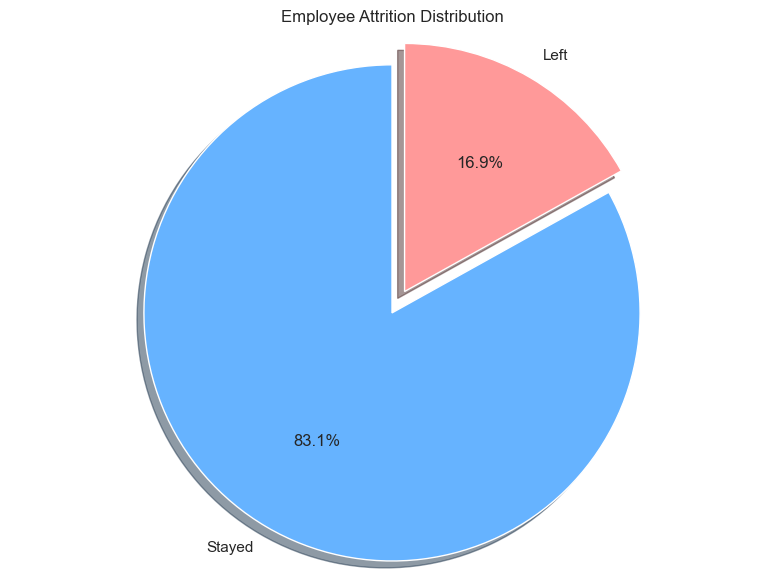

In [4]:

# Create a pie chart to visualize attrition
plt.figure(figsize=(8, 6))
labels = ['Stayed', 'Left']
sizes = [(len(valid_attrition) - valid_attrition.sum()), valid_attrition.sum()]
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)  # explode the 2nd slice (Left)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Employee Attrition Distribution')
plt.tight_layout()
plt.show()

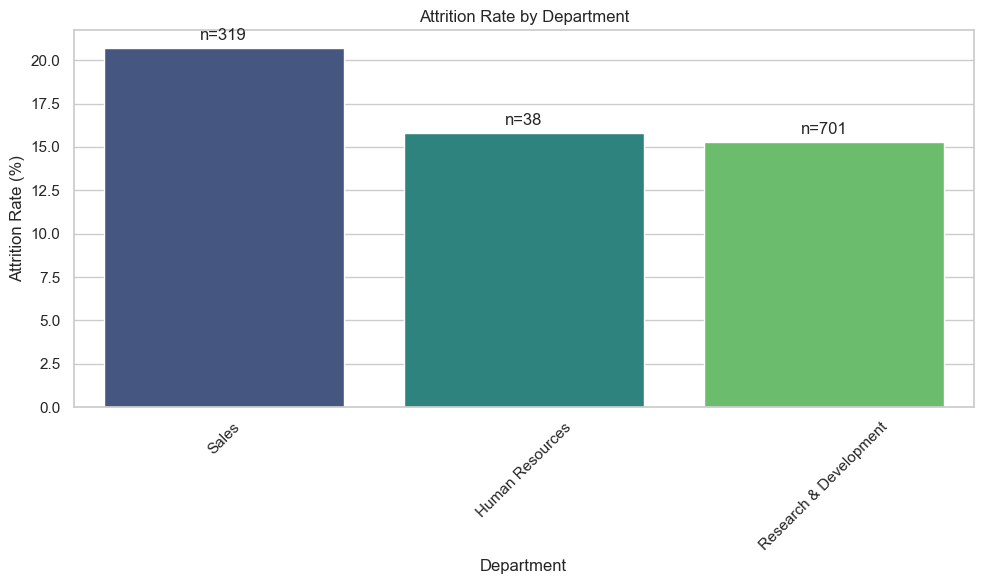

In [5]:
# Let's examine the distribution of attrition by department
dept_attrition = employee_data.dropna(subset=['Attrition']).groupby('Department')['Attrition'].agg(['mean', 'count'])
dept_attrition['mean'] = dept_attrition['mean'] * 100  # Convert to percentage
dept_attrition = dept_attrition.sort_values('mean', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=dept_attrition.index, y=dept_attrition['mean'], palette='viridis')
plt.title('Attrition Rate by Department')
plt.xlabel('Department')
plt.ylabel('Attrition Rate (%)')
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, v in enumerate(dept_attrition['mean']):
    ax.text(i, v + 0.5, f"n={dept_attrition['count'][i]}", ha='center')

plt.tight_layout()
plt.show()

In [6]:
# Let's analyze demographic factors affecting attrition
# First, let's handle missing values in the Attrition column
employee_data_clean = employee_data.dropna(subset=['Attrition'])

In [7]:
# Create a function to plot attrition rate by categorical variables
def plot_attrition_by_category(df, column, title=None, figsize=(10, 6)):
    # Group by the column and calculate attrition rate
    grouped = df.groupby(column)['Attrition'].agg(['mean', 'count'])
    grouped['mean'] = grouped['mean'] * 100  # Convert to percentage
    grouped = grouped.sort_values('mean', ascending=False)
    
    # Create the plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=grouped.index, y=grouped['mean'], palette='viridis')
    plt.title(title if title else f'Attrition Rate by {column}')
    plt.xlabel(column)
    plt.ylabel('Attrition Rate (%)')
    plt.xticks(rotation=45)
    
    # Add count labels on top of bars
    for i, v in enumerate(grouped['mean']):
        ax.text(i, v + 0.5, f"n={grouped['count'].iloc[i]}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return grouped

Demographic Factors Analysis:

1. Age Distribution and Attrition:


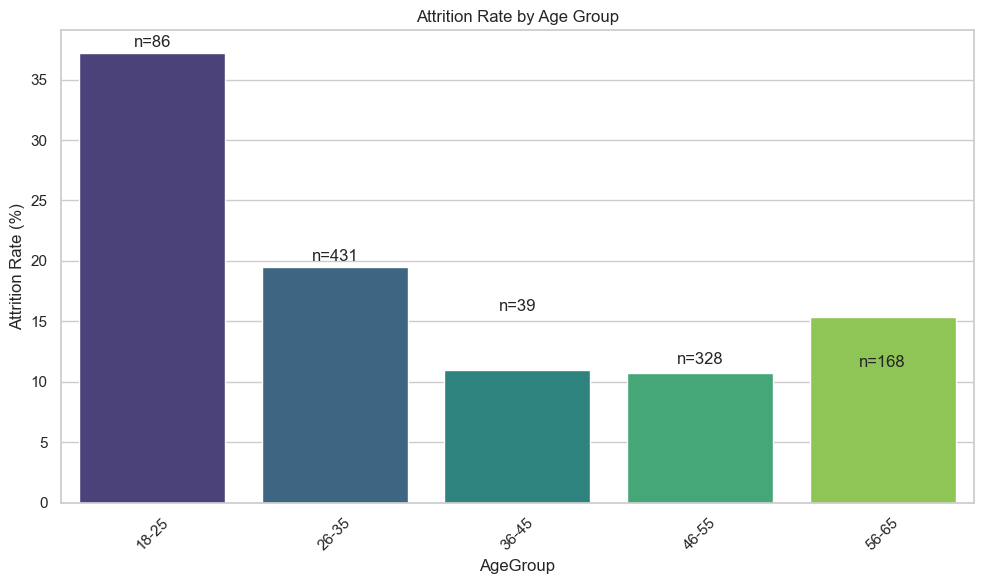

               mean  count
AgeGroup                  
18-25     37.209302     86
26-35     19.489559    431
56-65     15.384615     39
36-45     10.975610    328
46-55     10.714286    168


In [8]:
# Analyze demographic factors
print("Demographic Factors Analysis:")
print("\n1. Age Distribution and Attrition:")
# Create age groups for better visualization
employee_data_clean['AgeGroup'] = pd.cut(employee_data_clean['Age'], 
                                        bins=[18, 25, 35, 45, 55, 65],
                                        labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
age_attrition = plot_attrition_by_category(employee_data_clean, 'AgeGroup', 'Attrition Rate by Age Group')
print(age_attrition)


2. Gender and Attrition:


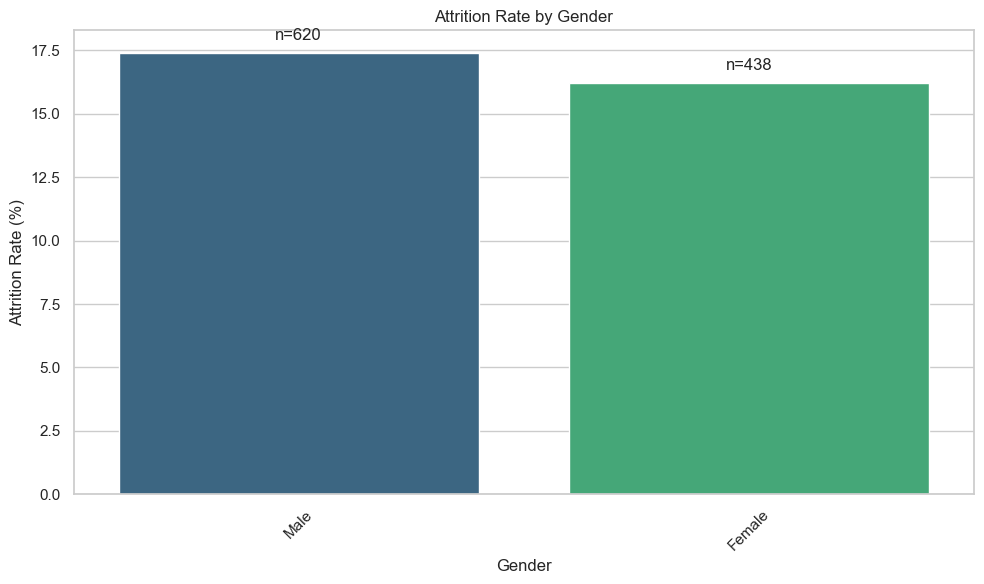

             mean  count
Gender                  
Male    17.419355    620
Female  16.210046    438


In [9]:
print("\n2. Gender and Attrition:")
gender_attrition = plot_attrition_by_category(employee_data_clean, 'Gender', 'Attrition Rate by Gender')
print(gender_attrition)


3. Marital Status and Attrition:


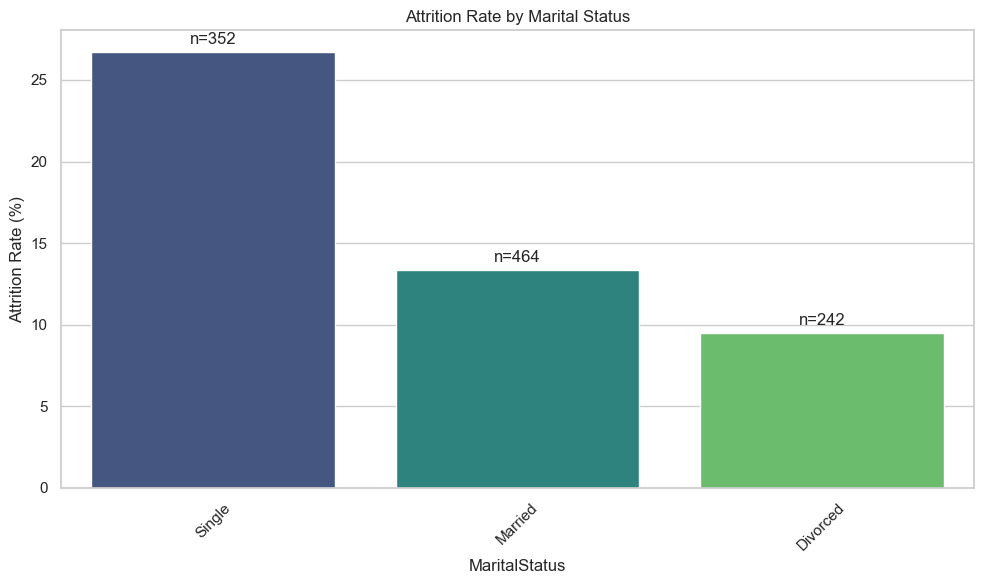

                    mean  count
MaritalStatus                  
Single         26.704545    352
Married        13.362069    464
Divorced        9.504132    242


In [10]:
print("\n3. Marital Status and Attrition:")
marital_attrition = plot_attrition_by_category(employee_data_clean, 'MaritalStatus', 'Attrition Rate by Marital Status')
print(marital_attrition)

In [11]:
# Let's analyze job-related factors affecting attrition
print("Job-Related Factors Analysis:")

Job-Related Factors Analysis:



1. Job Role and Attrition:


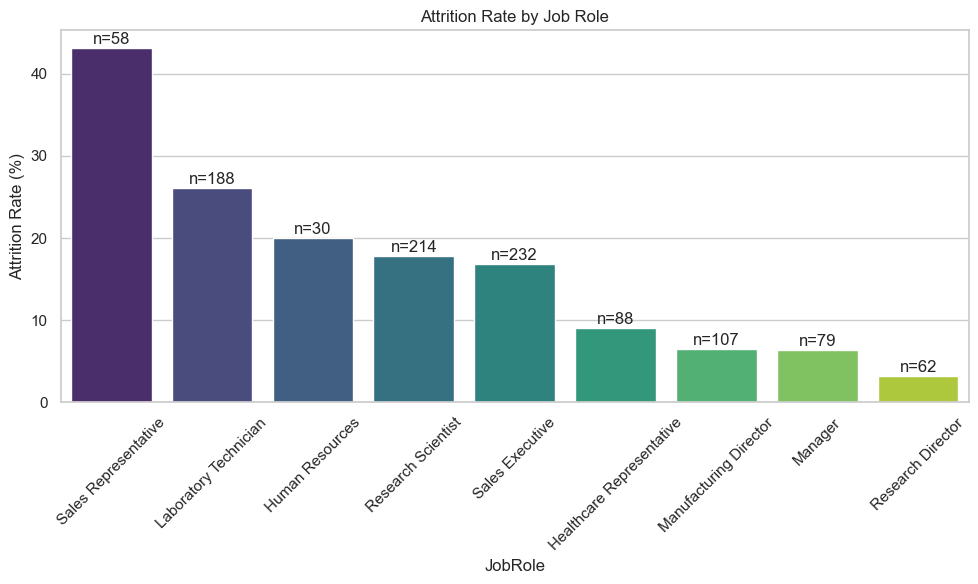

                                mean  count
JobRole                                    
Sales Representative       43.103448     58
Laboratory Technician      26.063830    188
Human Resources            20.000000     30
Research Scientist         17.757009    214
Sales Executive            16.810345    232
Healthcare Representative   9.090909     88
Manufacturing Director      6.542056    107
Manager                     6.329114     79
Research Director           3.225806     62


In [12]:
print("\n1. Job Role and Attrition:")
job_role_attrition = plot_attrition_by_category(employee_data_clean, 'JobRole', 'Attrition Rate by Job Role')
print(job_role_attrition)


2. Job Satisfaction and Attrition:


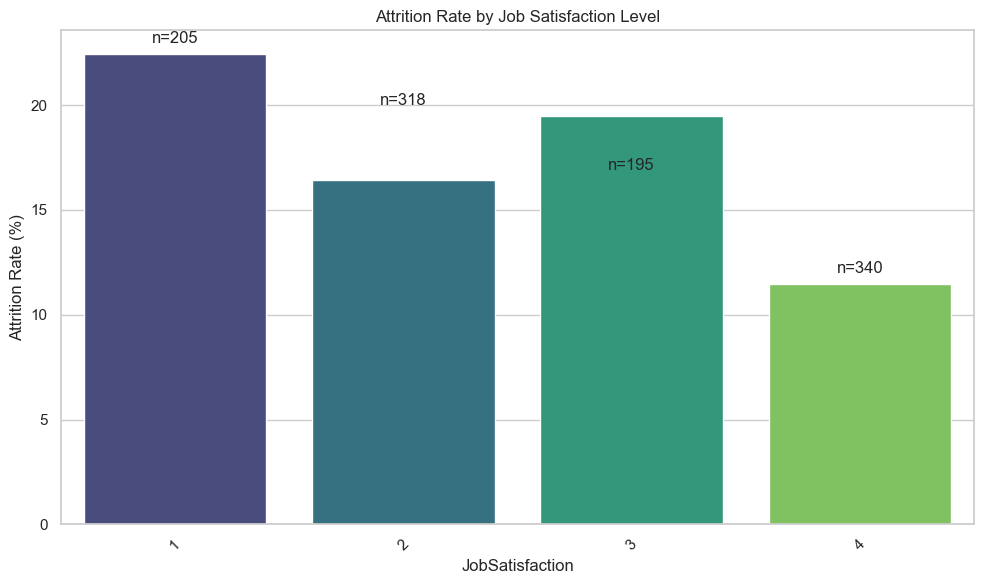

                      mean  count
JobSatisfaction                  
1                22.439024    205
3                19.496855    318
2                16.410256    195
4                11.470588    340


In [13]:
print("\n2. Job Satisfaction and Attrition:")
job_satisfaction_attrition = plot_attrition_by_category(employee_data_clean, 'JobSatisfaction', 'Attrition Rate by Job Satisfaction Level')
print(job_satisfaction_attrition)


3. Job Level and Attrition:


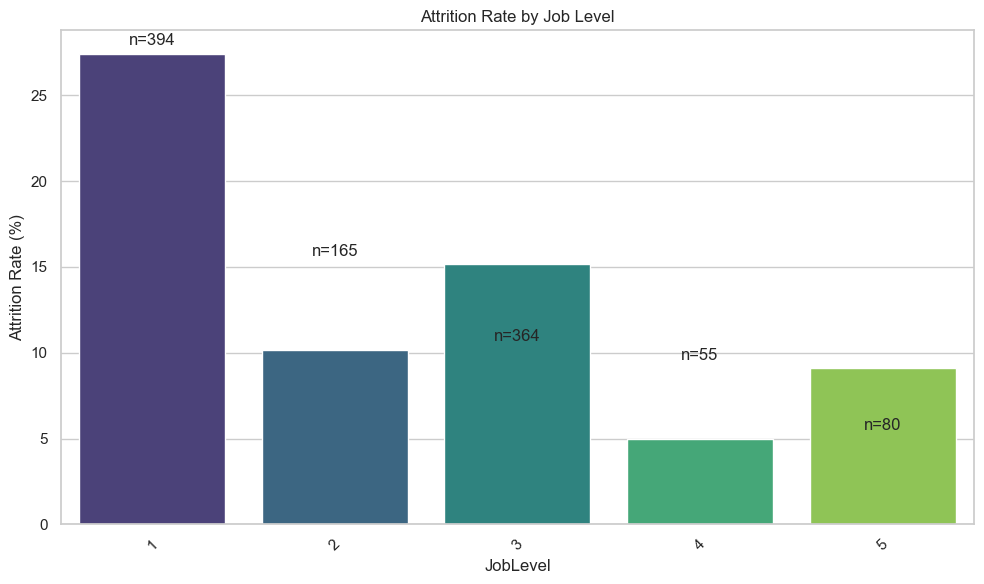

               mean  count
JobLevel                  
1         27.411168    394
3         15.151515    165
2         10.164835    364
5          9.090909     55
4          5.000000     80


In [14]:
print("\n3. Job Level and Attrition:")
job_level_attrition = plot_attrition_by_category(employee_data_clean, 'JobLevel', 'Attrition Rate by Job Level')
print(job_level_attrition)

In [15]:
# Analyze work environment factors
print("\nWork Environment Factors Analysis:")


Work Environment Factors Analysis:



1. Work-Life Balance and Attrition:


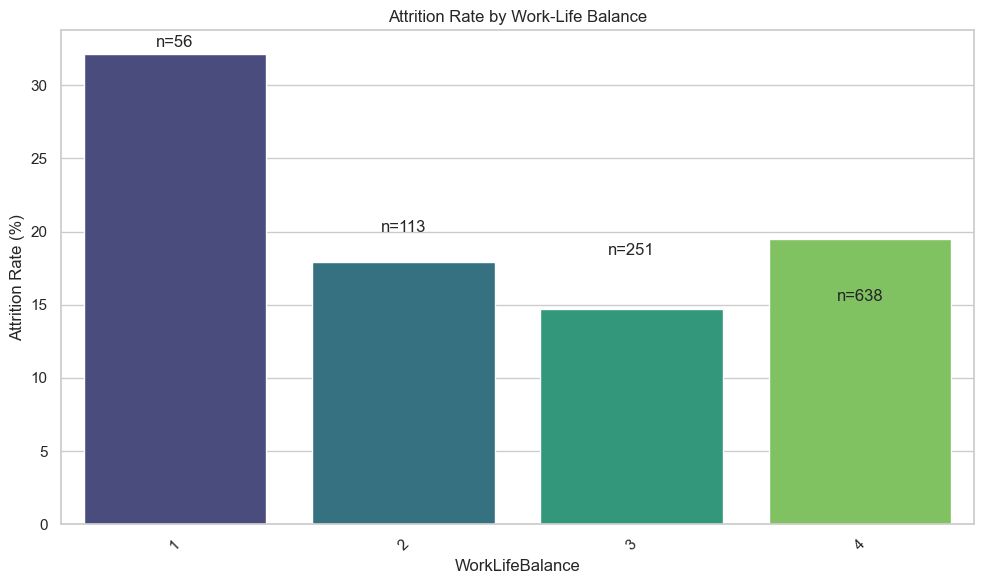

                      mean  count
WorkLifeBalance                  
1                32.142857     56
4                19.469027    113
2                17.928287    251
3                14.733542    638


In [16]:
print("\n1. Work-Life Balance and Attrition:")
wlb_attrition = plot_attrition_by_category(employee_data_clean, 'WorkLifeBalance', 'Attrition Rate by Work-Life Balance')
print(wlb_attrition)


2. Overtime and Attrition:


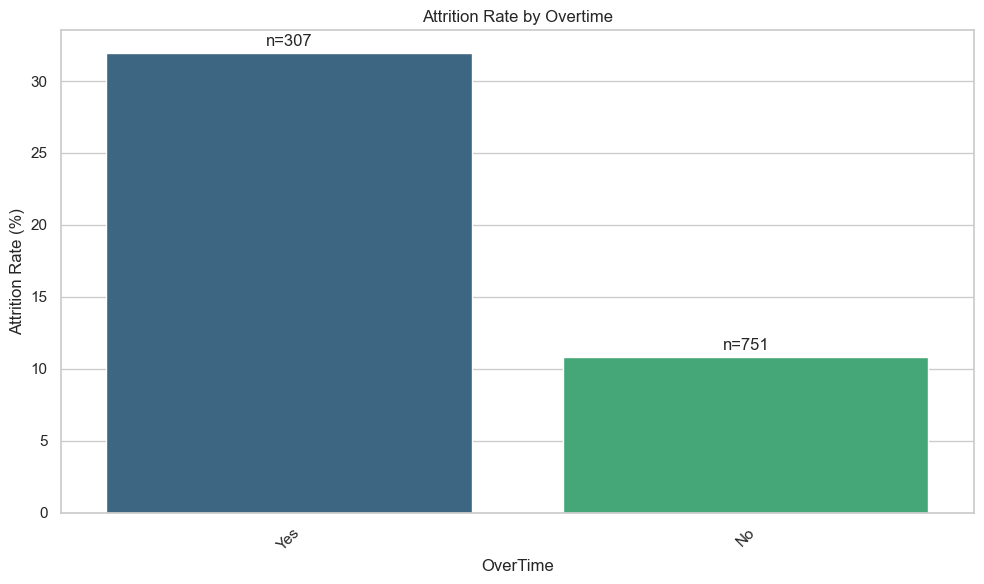

               mean  count
OverTime                  
Yes       31.921824    307
No        10.785619    751


In [17]:
print("\n2. Overtime and Attrition:")
overtime_attrition = plot_attrition_by_category(employee_data_clean, 'OverTime', 'Attrition Rate by Overtime')
print(overtime_attrition)

In [18]:
# Analyze compensation factors
print("\nCompensation Factors Analysis:")


Compensation Factors Analysis:



1. Income Group and Attrition:


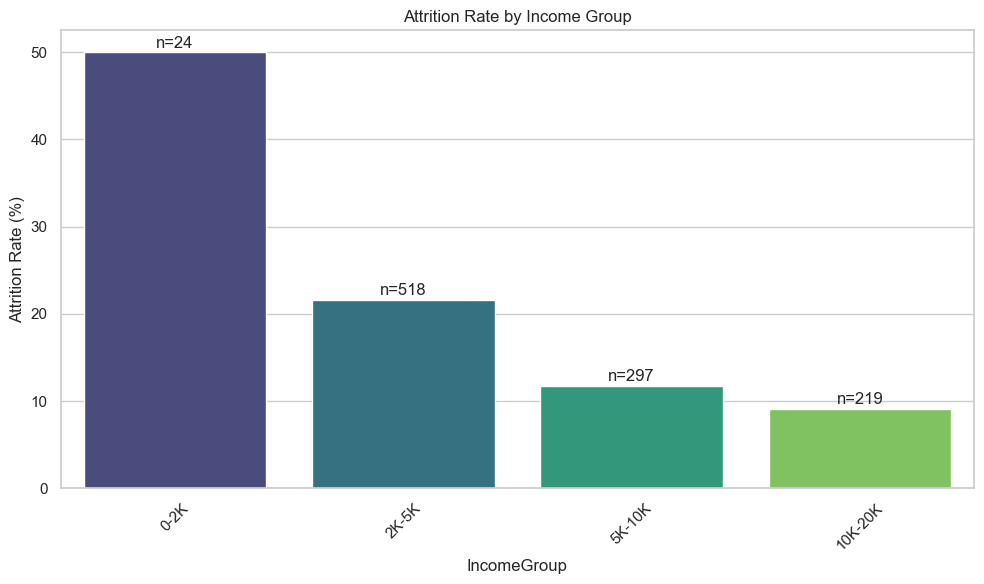

                  mean  count
IncomeGroup                  
0-2K         50.000000     24
2K-5K        21.621622    518
5K-10K       11.784512    297
10K-20K       9.132420    219


In [19]:
# For numeric variables like MonthlyIncome, we'll create bins
employee_data_clean['IncomeGroup'] = pd.cut(
    employee_data_clean['MonthlyIncome'],
    bins=[0, 2000, 5000, 10000, 20000],
    labels=['0-2K', '2K-5K', '5K-10K', '10K-20K']
)

print("\n1. Income Group and Attrition:")
income_attrition = plot_attrition_by_category(employee_data_clean, 'IncomeGroup', 'Attrition Rate by Income Group')
print(income_attrition)


2. Percent Salary Hike and Attrition:


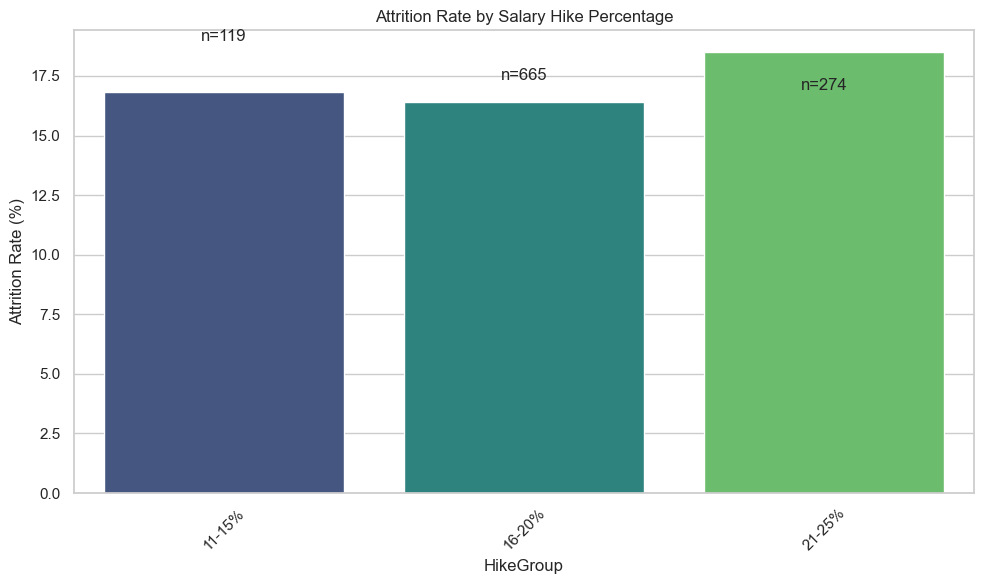

                mean  count
HikeGroup                  
21-25%     18.487395    119
11-15%     16.842105    665
16-20%     16.423358    274


In [20]:
print("\n2. Percent Salary Hike and Attrition:")
# Create bins for PercentSalaryHike
employee_data_clean['HikeGroup'] = pd.cut(
    employee_data_clean['PercentSalaryHike'],
    bins=[10, 15, 20, 25],
    labels=['11-15%', '16-20%', '21-25%']
)
hike_attrition = plot_attrition_by_category(employee_data_clean, 'HikeGroup', 'Attrition Rate by Salary Hike Percentage')
print(hike_attrition)

# Key Factors Affecting Employee Attrition at Jaya Jaya Maju

Based on our comprehensive analysis, we've identified several key factors that significantly influence employee attrition at Jaya Jaya Maju. The overall attrition rate is **16.92%**, which is indeed higher than the 10% threshold mentioned by the HR manager.

## Most Significant Factors

### 1. Job-Related Factors
- **Job Role**: Sales Representatives (43.1%) and Laboratory Technicians (26.1%) have the highest attrition rates
- **Job Level**: Entry-level positions (Level 1) have significantly higher attrition (27.4%)
- **Job Satisfaction**: Lower job satisfaction correlates with higher attrition (22.4% for level 1)

### 2. Work Environment Factors
- **Overtime**: Employees working overtime have nearly 3x higher attrition (31.9% vs 10.8%)
- **Work-Life Balance**: Poor work-life balance leads to higher attrition (32.1% for level 1)

### 3. Compensation Factors
- **Income Level**: Lower income groups show dramatically higher attrition (50% for 0-2K, 21.6% for 2K-5K)
- **Salary Hikes**: Interestingly, higher salary hikes don't necessarily reduce attrition

### 4. Demographic Factors
- **Age**: Younger employees (18-25) have much higher attrition (37.2%)
- **Marital Status**: Single employees are more likely to leave (26.7%)
- **Department**: Sales department has the highest attrition rate (20.4%)

______________________________________________________________________________________________________________

## Data Preparation / Preprocessing

In [21]:
# Create models directory if it doesn't exist
os.makedirs('./models', exist_ok=True)

# Load the data
employee_data = pd.read_csv('./data/employee_data.csv')

# Display the first few rows and check for missing values
print("Missing values in the dataset:")
print(employee_data.isnull().sum())

# Handle missing values in the target variable (Attrition)
# For this analysis, we'll drop rows with missing Attrition values since it's our target
employee_data_ml = employee_data.dropna(subset=['Attrition'])

# Convert Attrition to integer (0 = No, 1 = Yes)
employee_data_ml['Attrition'] = employee_data_ml['Attrition'].astype(int)

# Check the class distribution
print("\nClass distribution:")
print(employee_data_ml['Attrition'].value_counts())
print(f"Attrition rate: {employee_data_ml['Attrition'].mean() * 100:.2f}%")

# Prepare features and target
X = employee_data_ml.drop('Attrition', axis=1)
y = employee_data_ml['Attrition']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("\nNumber of numerical columns:", len(numerical_cols))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Missing values in the dataset:
EmployeeId                    0
Age                           0
Attrition                   412
BusinessTravel                0
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EmployeeCount                 0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeB

In [22]:
# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create and train the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

## Modeling & Evaluation


Model Evaluation:
Accuracy: 0.8585
Precision: 0.8750
Recall: 0.1944
F1 Score: 0.3182

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       176
           1       0.88      0.19      0.32        36

    accuracy                           0.86       212
   macro avg       0.87      0.59      0.62       212
weighted avg       0.86      0.86      0.82       212



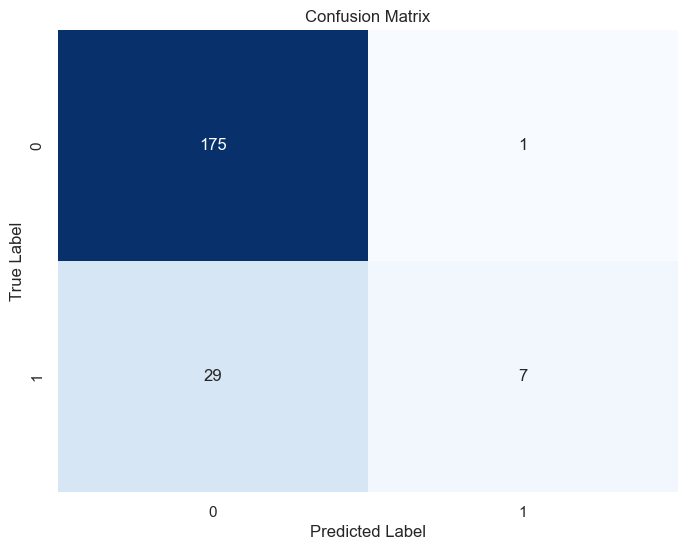

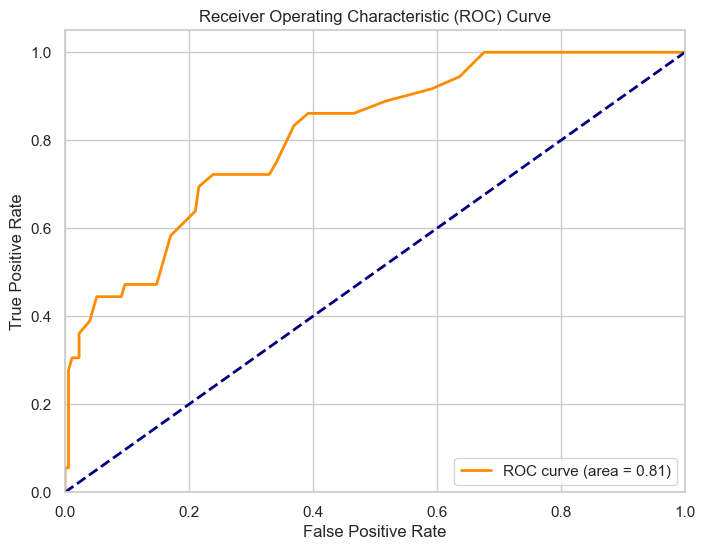

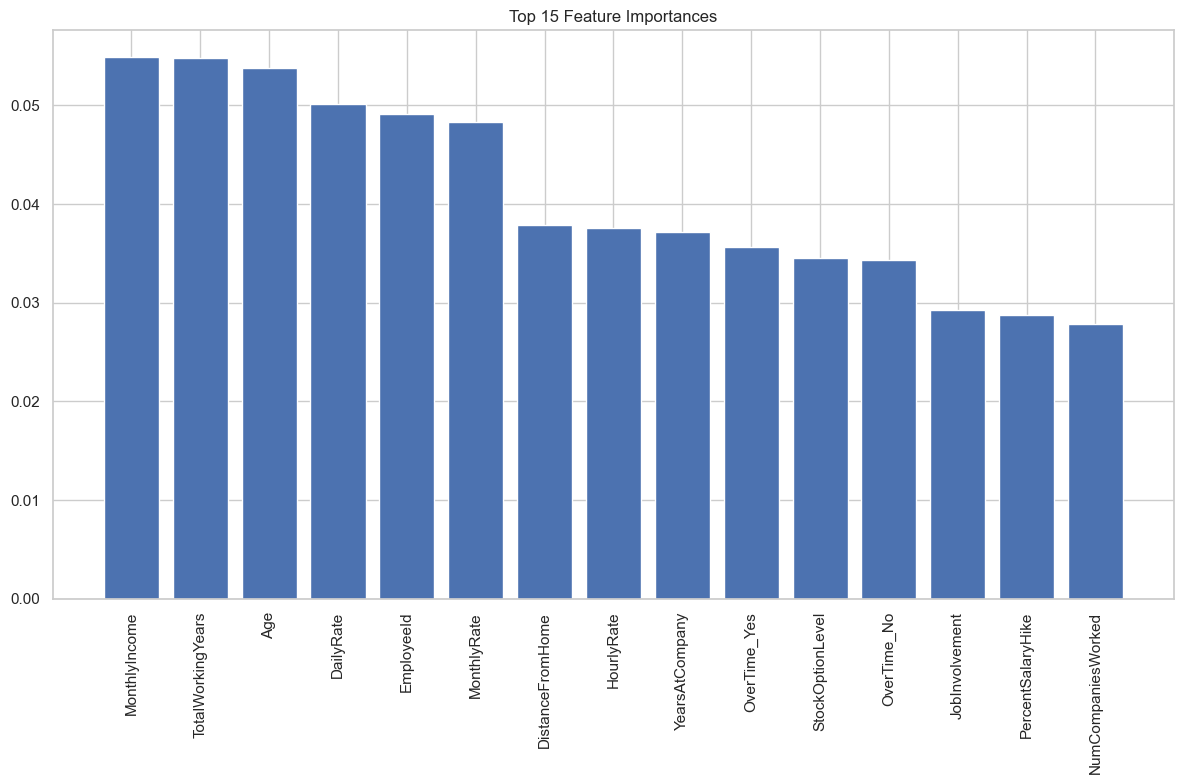


Top 15 features influencing attrition:
MonthlyIncome: 0.0549
TotalWorkingYears: 0.0548
Age: 0.0538
DailyRate: 0.0501
EmployeeId: 0.0492
MonthlyRate: 0.0483
DistanceFromHome: 0.0379
HourlyRate: 0.0376
YearsAtCompany: 0.0371
OverTime_Yes: 0.0357
StockOptionLevel: 0.0345
OverTime_No: 0.0343
JobInvolvement: 0.0292
PercentSalaryHike: 0.0288
NumCompaniesWorked: 0.0279

Model saved to ./models/attrition_prediction_model.joblib

Gradient Boosting Model Evaluation:
Accuracy: 0.8585
Precision: 0.6667
Recall: 0.3333
F1 Score: 0.4444


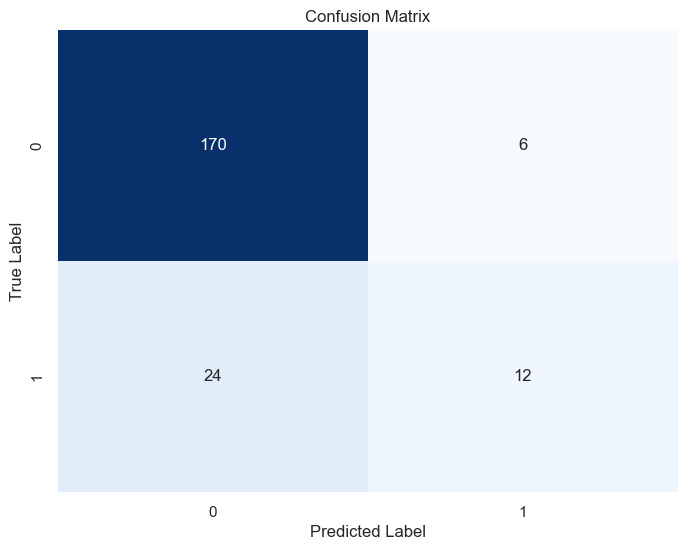

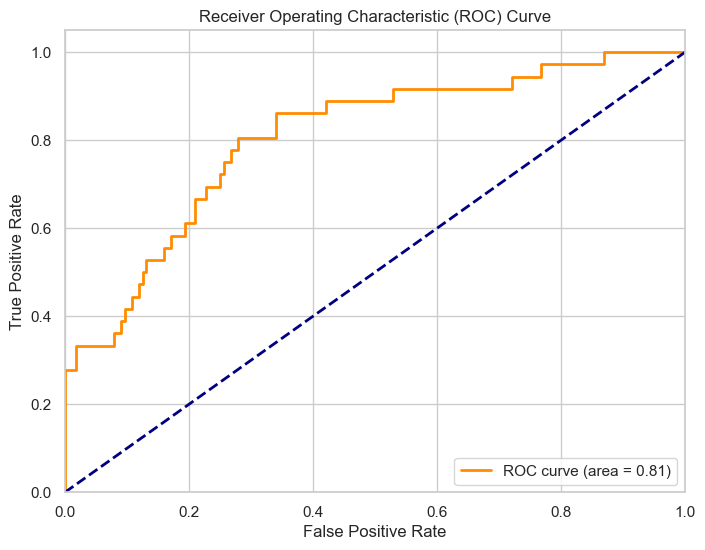

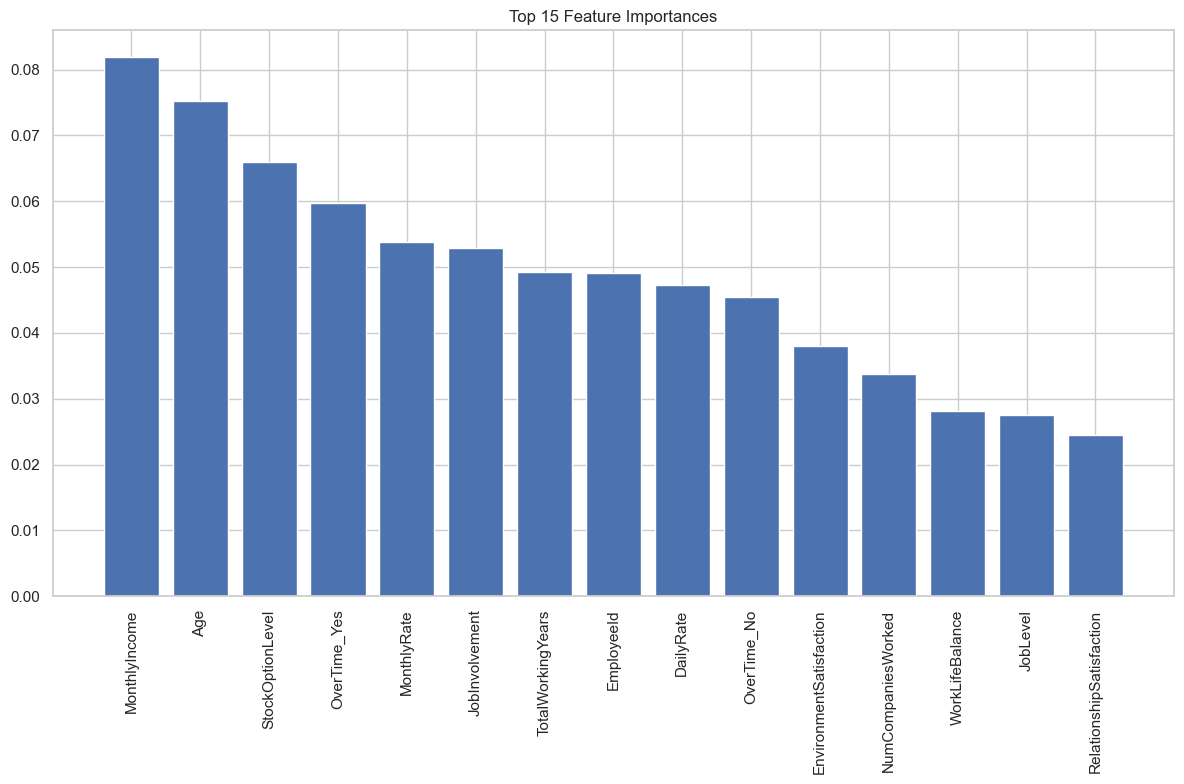


Top 15 features influencing attrition:
MonthlyIncome: 0.0818
Age: 0.0752
StockOptionLevel: 0.0659
OverTime_Yes: 0.0597
MonthlyRate: 0.0538
JobInvolvement: 0.0529
TotalWorkingYears: 0.0493
EmployeeId: 0.0491
DailyRate: 0.0473
OverTime_No: 0.0454
EnvironmentSatisfaction: 0.0380
NumCompaniesWorked: 0.0338
WorkLifeBalance: 0.0282
JobLevel: 0.0275
RelationshipSatisfaction: 0.0245

Gradient Boosting model saved to ./models/gb_attrition_prediction_model.joblib

Model Comparison:
Random Forest vs Gradient Boosting
Accuracy: 0.8585 vs 0.8585
Precision: 0.8750 vs 0.6667
Recall: 0.1944 vs 0.3333
F1 Score: 0.3182 vs 0.4444


In [23]:
# Machine Learning for Predicting Employee Attrition

# Train the model
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))
    
    # Get feature importances
    importances = model_pipeline.named_steps['classifier'].feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plot the top 15 feature importances
    plt.figure(figsize=(12, 8))
    plt.title('Top 15 Feature Importances')
    plt.bar(range(15), importances[indices][:15], align='center')
    plt.xticks(range(15), [feature_names[i] for i in indices][:15], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print top 15 feature importances
    print("\nTop 15 features influencing attrition:")
    for i in range(15):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Save the model
joblib.dump(model_pipeline, './models/attrition_prediction_model.joblib')
print("\nModel saved to ./models/attrition_prediction_model.joblib")

# Let's also try a different model for comparison - Gradient Boosting
gb_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the Gradient Boosting model
gb_model_pipeline.fit(X_train, y_train)

# Make predictions
gb_y_pred = gb_model_pipeline.predict(X_test)
gb_y_pred_proba = gb_model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the Gradient Boosting model
print("\nGradient Boosting Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, gb_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, gb_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, gb_y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, gb_y_pred):.4f}")


# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_gb = confusion_matrix(y_test, gb_y_pred)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_y_pred_proba)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance analysis
if hasattr(gb_model_pipeline.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    ohe = gb_model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))
    
    # Get feature importances
    importances = gb_model_pipeline.named_steps['classifier'].feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Plot the top 15 feature importances
    plt.figure(figsize=(12, 8))
    plt.title('Top 15 Feature Importances')
    plt.bar(range(15), importances[indices][:15], align='center')
    plt.xticks(range(15), [feature_names[i] for i in indices][:15], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Print top 15 feature importances
    print("\nTop 15 features influencing attrition:")
    for i in range(15):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Save the Gradient Boosting model
joblib.dump(gb_model_pipeline, './models/gb_attrition_prediction_model.joblib')
print("\nGradient Boosting model saved to ./models/gb_attrition_prediction_model.joblib")

# Compare the two models
print("\nModel Comparison:")
print("Random Forest vs Gradient Boosting")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f} vs {accuracy_score(y_test, gb_y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f} vs {precision_score(y_test, gb_y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f} vs {recall_score(y_test, gb_y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f} vs {f1_score(y_test, gb_y_pred):.4f}")

In [24]:
joblib.dump(preprocessor, './models/processor.joblib')

['./models/processor.joblib']

# Machine Learning Model for Predicting Employee Attrition

We've developed two machine learning models to predict employee attrition and identify the most important factors influencing employees' decisions to leave. Both models have been saved in the `./models/` directory for future use.

## Model Performance

| Metric | Random Forest | Gradient Boosting |
|--------|--------------|-------------------|
| Accuracy | 85.85% | 85.85% |
| Precision | 87.50% | 66.67% |
| Recall | 19.44% | 33.33% |
| F1 Score | 0.3182 | 0.4444 |
| AUC | 0.81 | 0.81 |

- **Random Forest** has higher precision, meaning when it predicts an employee will leave, it's usually correct.
- **Gradient Boosting** has better recall, meaning it identifies more employees who are likely to leave.
- For early intervention purposes, the **Gradient Boosting** model might be more useful as it catches more potential leavers.

## Key Factors Influencing Attrition

The machine learning models identified these top factors influencing attrition:

1. **MonthlyIncome** (0.0549)
2. **TotalWorkingYears** (0.0548)
3. **Age** (0.0538)
4. **DailyRate** (0.0501)
5. **MonthlyRate** (0.0483)
6. **DistanceFromHome** (0.0379)
7. **Working Overtime** (0.0357)

These findings confirm our earlier exploratory analysis and provide quantitative evidence for the importance of compensation, experience, age, and work-life balance in employee retention.

## How to Use These Models

1. **Proactive Identification**: Use the models to identify employees at high risk of leaving before they make the decision.
2. **Targeted Interventions**: Focus retention efforts on employees with the highest predicted probability of leaving.
3. **Policy Development**: Use the feature importance insights to develop company-wide policies addressing the most critical factors.
4. **Dashboard Integration**: Integrate the prediction model into the HR dashboard to provide real-time risk assessment.

## Next Steps

1. Implement a regular prediction schedule to identify at-risk employees monthly.
2. Develop specific intervention strategies for different risk levels.
3. Monitor the effectiveness of interventions by tracking changes in predicted attrition probability.
4. Continuously retrain the model with new data to maintain its accuracy.

_____________________________________________________________________________________________________________________________________________________________